In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer, ModeClusterer_HDBSCAN  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import get_mpe_data
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [5]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2_C02'
data_path = "../../data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
weather_data_path = "../../data/nw2/mvbc_data.parquet"

turbine_data = pd.read_parquet(data_path)
weather_station_data_LAT = pd.read_parquet(weather_data_path)
#rated_data = get_rated_data(data)
#parked_data = get_parked_data(data)

In [6]:
mpe_data = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_data[direction] = get_mpe_data(turbine_data, direction, name_location)

In [7]:
mc = {}
clustering_data = {}
clustered_modes = {}
modes = {}

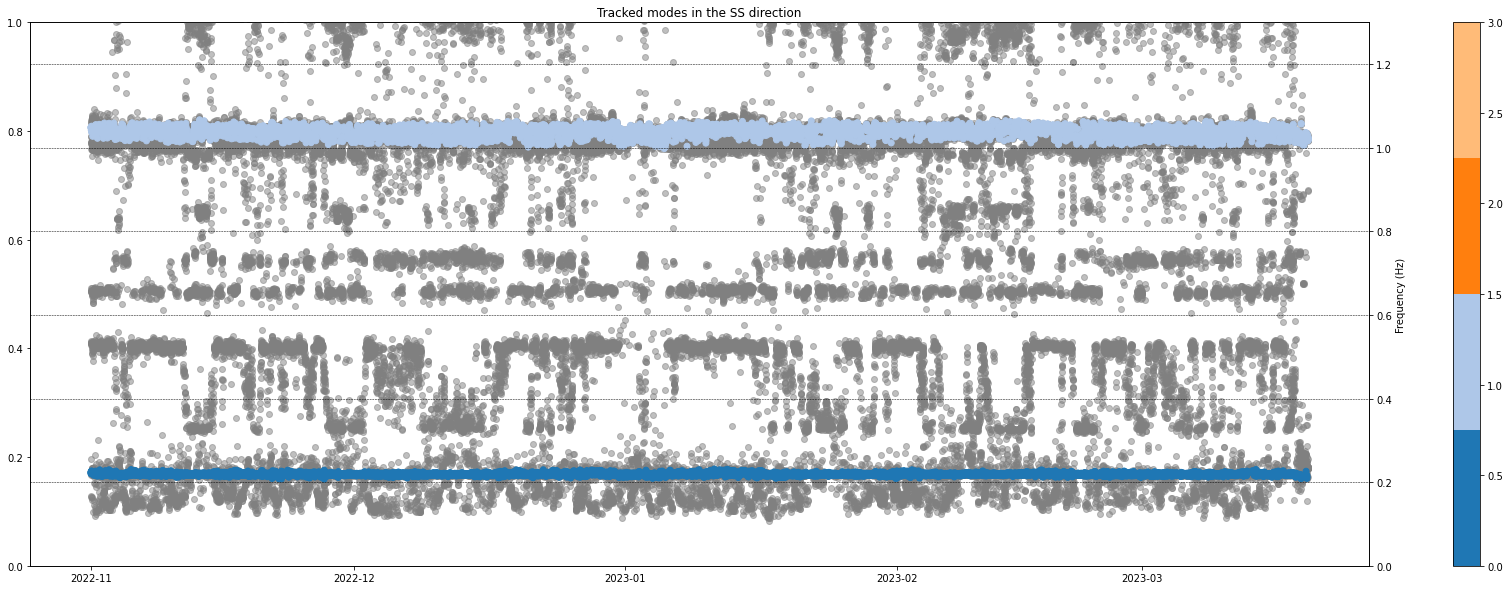

In [16]:
direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 10},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)

plt.show()

SS1 = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS1 = SS1[~SS1.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2 = clustered_modes[direction][clustered_modes[direction].labels == 1]
SS2 = SS2[~SS2.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

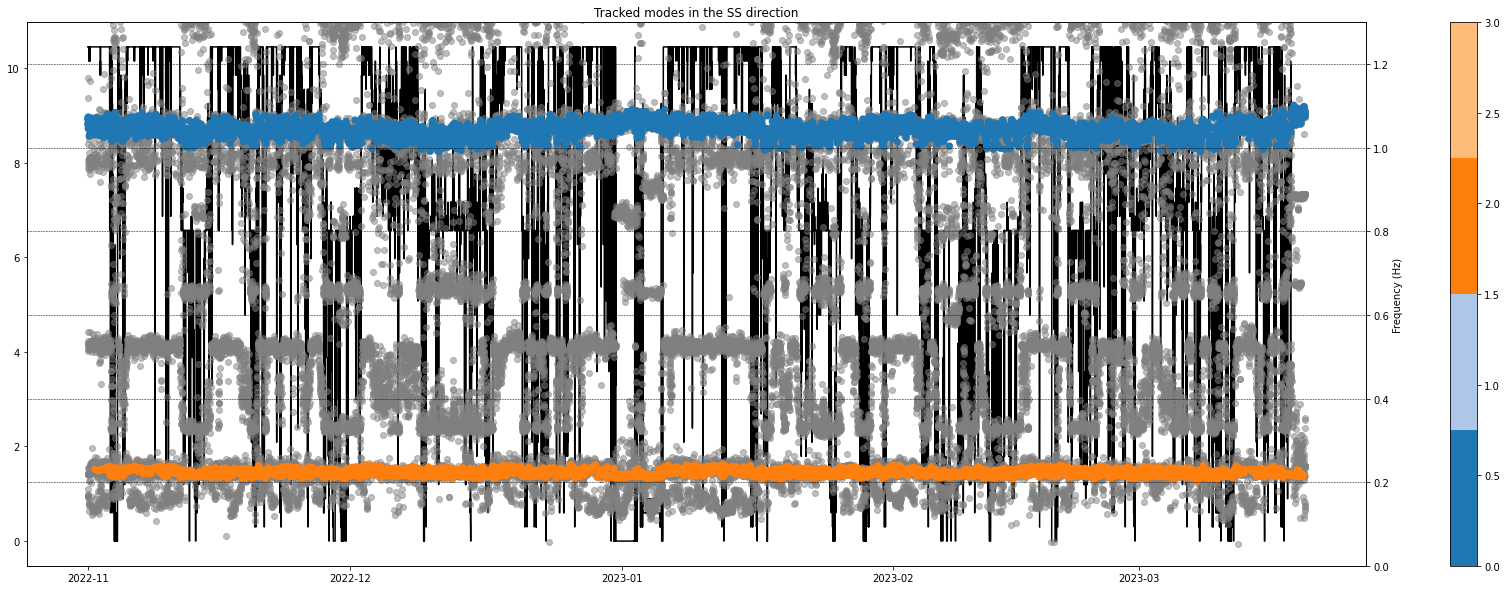

In [17]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 3, "damping": 1},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)
plt.show()

FA1 = clustered_modes[direction][clustered_modes[direction].labels == 2]
FA1 = FA1[~FA1.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
FA2 = clustered_modes[direction][clustered_modes[direction].labels == 0]
FA2 = FA2[~FA2.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

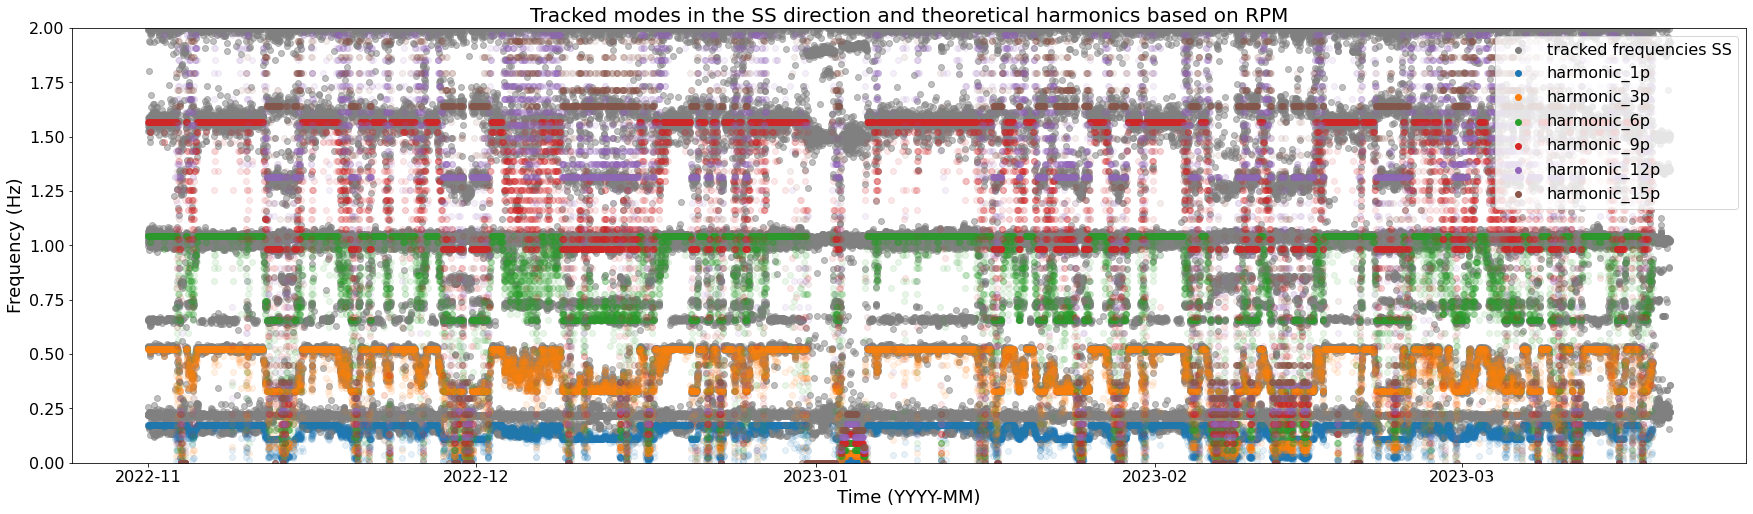

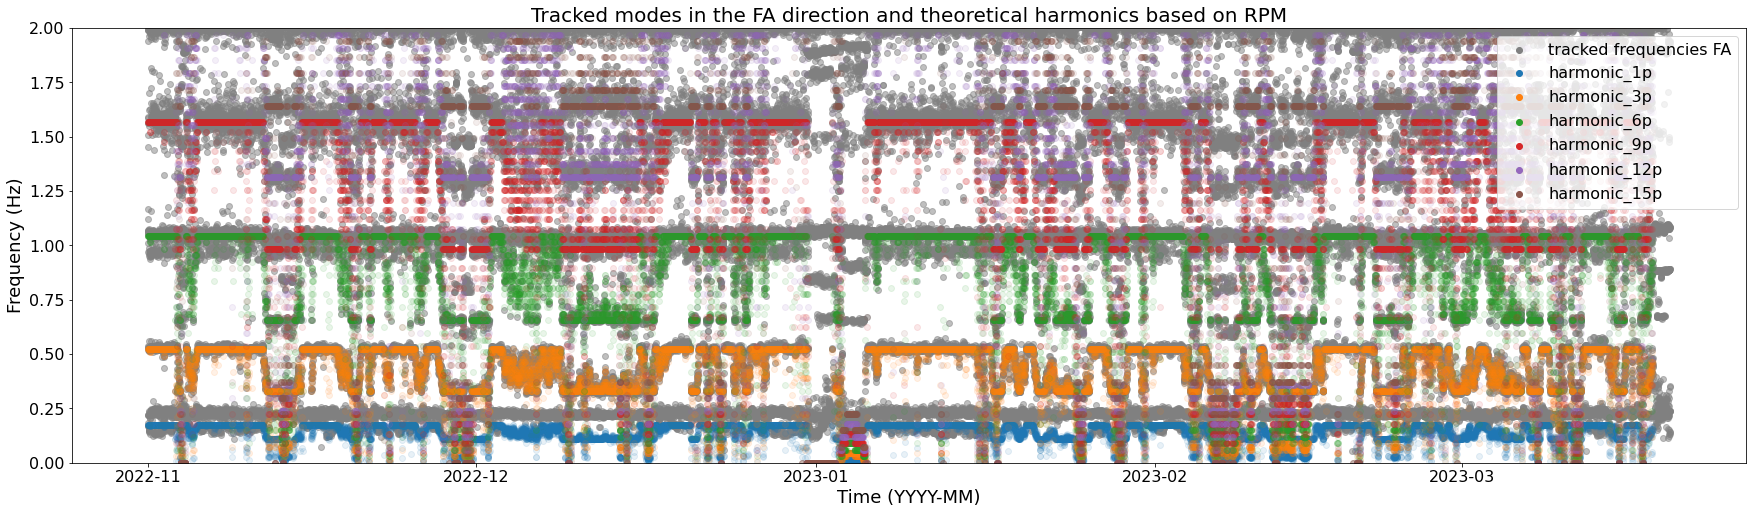

In [18]:
from oma_tracking.modal_tracking.harmonics import theoretical_harmonic
theoretical_harmonics = theoretical_harmonic(turbine_data, p_orders=[1,3,6,9,12,15])

for direction in ['SS', 'FA']:
    plt.figure(figsize = (30,8))
    plt.scatter(clustering_data[direction].index, clustering_data[direction].frequency, c='grey', alpha=0.5, label = 'tracked frequencies ' + direction)
    for col in theoretical_harmonics.columns:
        plt.scatter(theoretical_harmonics[col].index, theoretical_harmonics[col].values, alpha=0.1, label=col)
    plt.ylim(0, 2)
    plt.title('Tracked modes in the ' + direction + ' direction and theoretical harmonics based on RPM', fontsize=20)
    plt.xlabel('Time (YYYY-MM)', fontsize=18)
    plt.ylabel('Frequency (Hz)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    legend = plt.legend(loc='upper right', fontsize=16)
    for handle in legend.legendHandles:
        handle.set_alpha(1.0)
    plt.show()

SS


c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


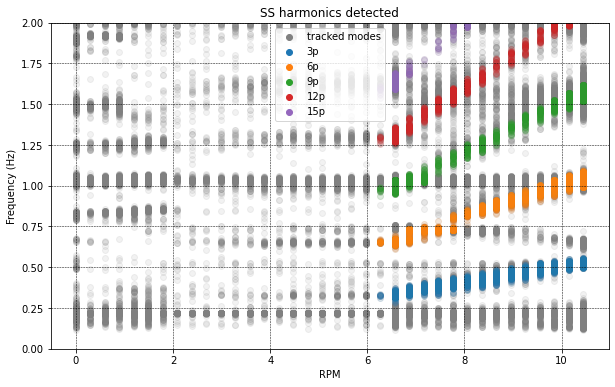

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


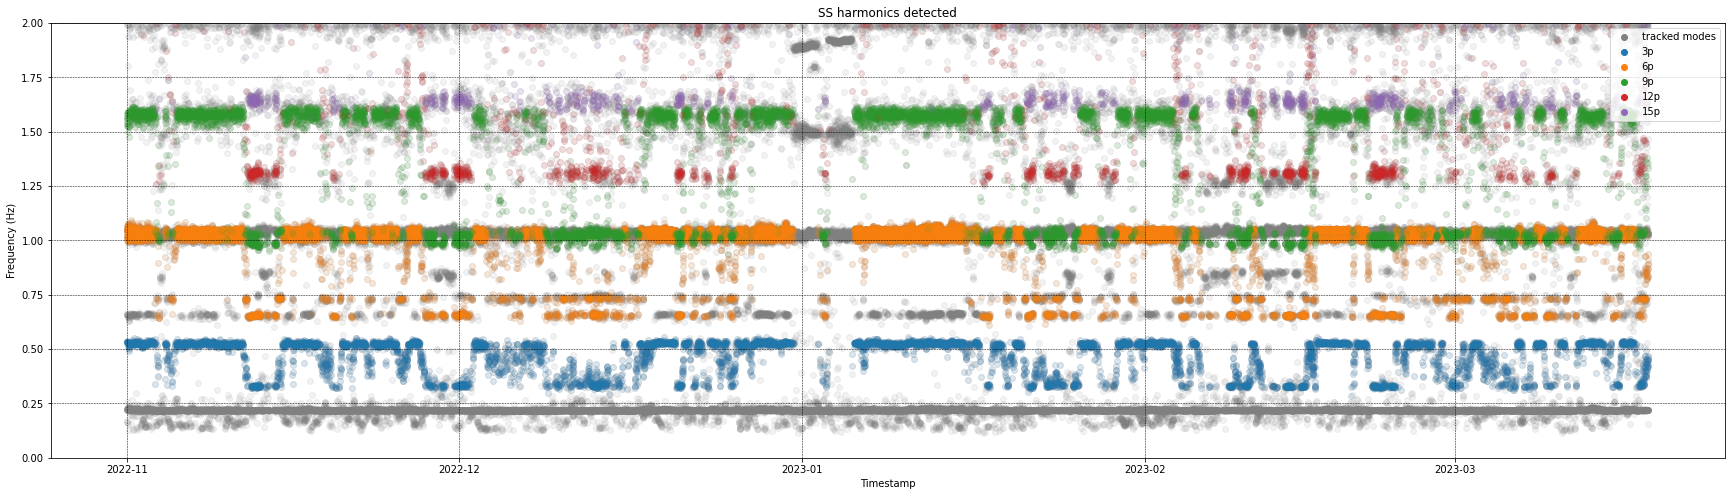

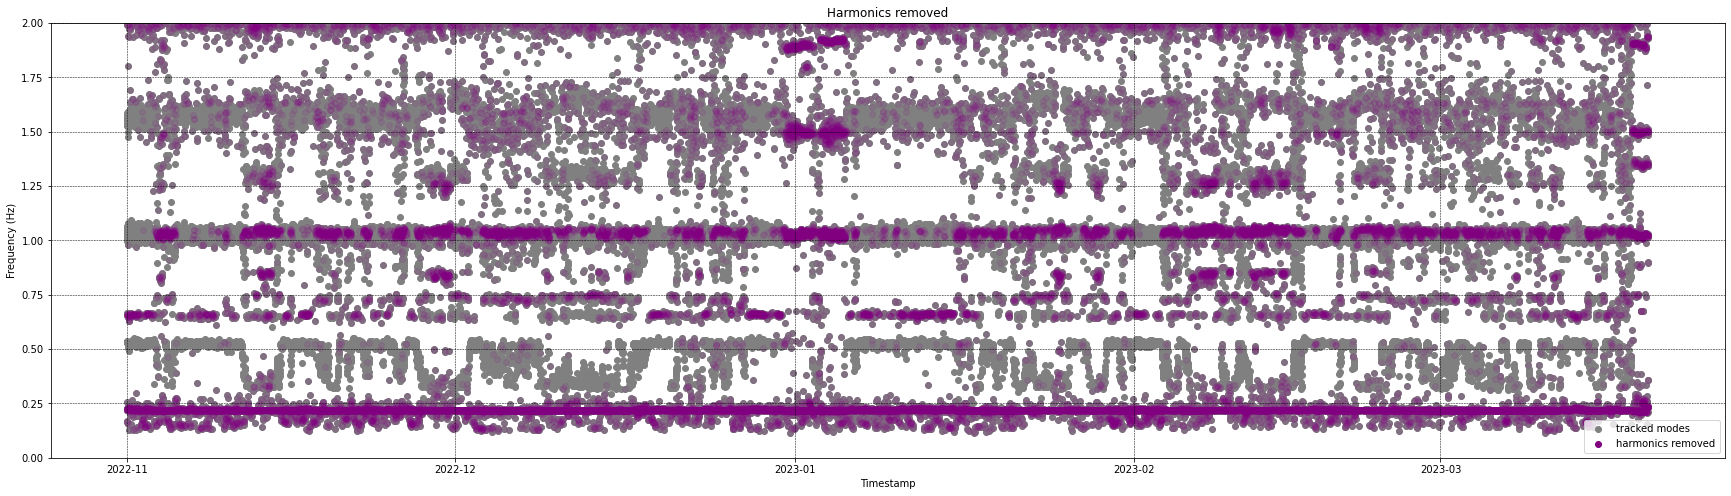

FA


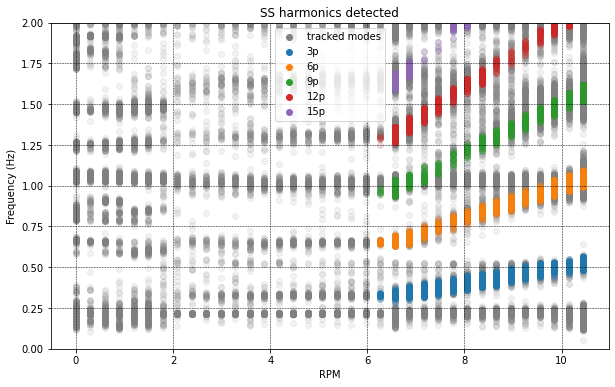

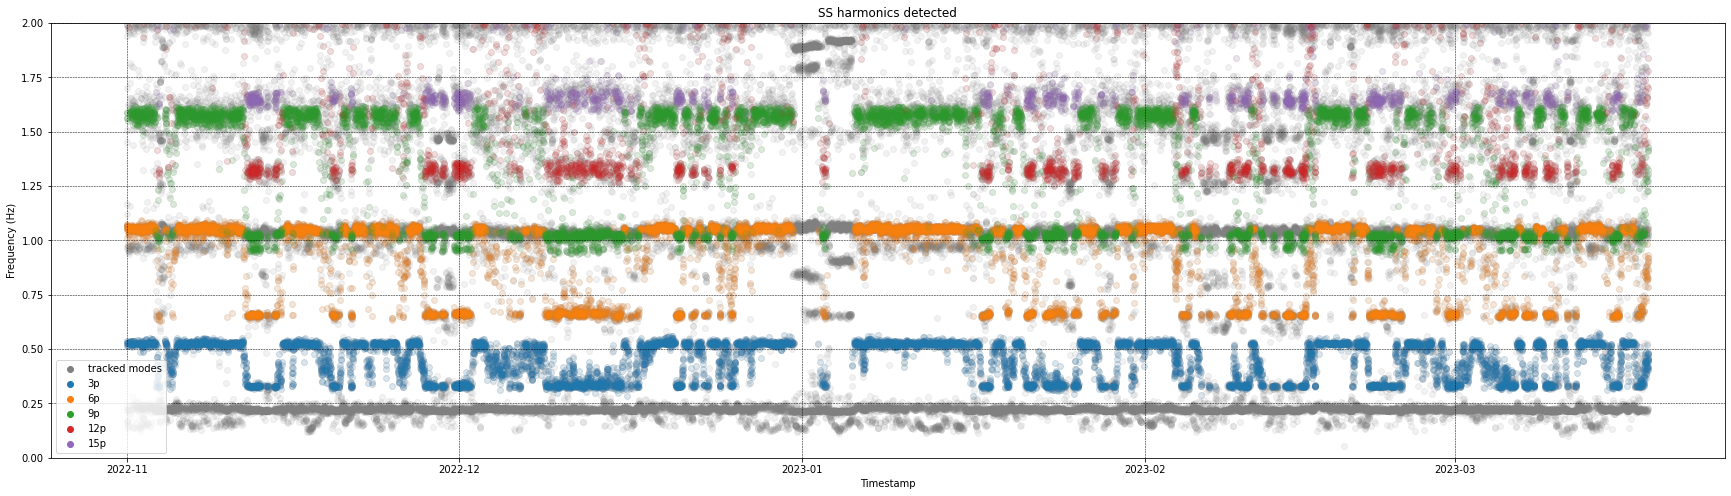

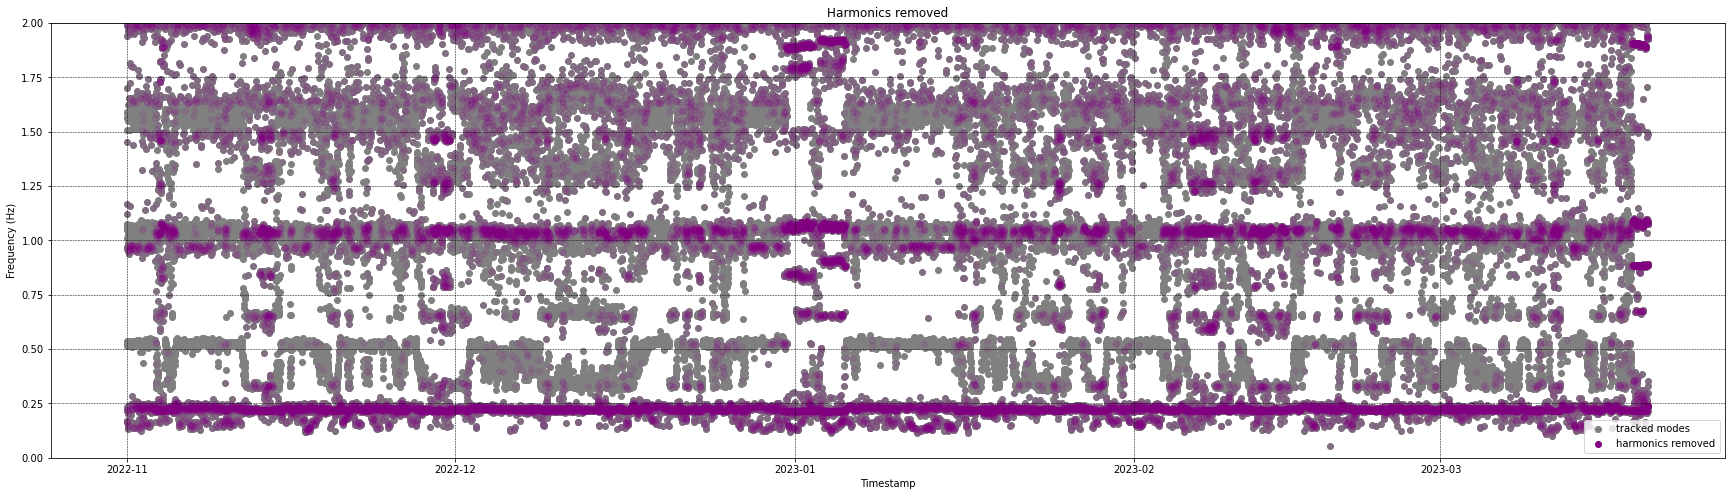

In [19]:
from oma_tracking.modal_tracking.harmonics import HarmonicDetector
harmonic_detectors = {}
harmonics_removed = {}
for direction in ['SS', 'FA']:
    print(direction)
    harmonic_detectors[direction] = HarmonicDetector(turbine_data, clustering_data[direction], p_orders=[3,6,9,12, 15])
    distance_calculator_data = harmonic_detectors[direction].get_distance_calculator_data()
    harmonic_detectors[direction].plot_distances()
    harmonic_detectors[direction].plot_harmonics_removed()
    harmonics_removed[direction] = harmonic_detectors[direction].remove_harmonics()


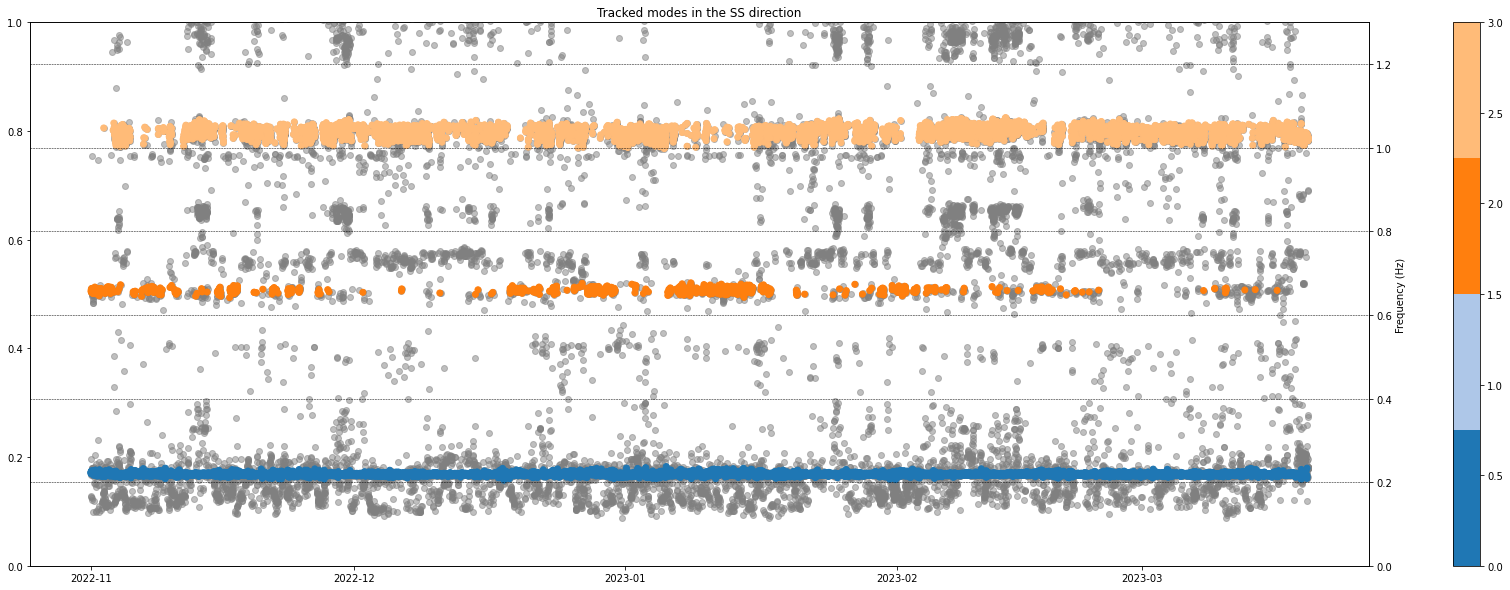

In [20]:
direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)

plt.show()

SS1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS1_harmonics_removed = SS1_harmonics_removed[~SS1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 3]
SS2_harmonics_removed = SS2_harmonics_removed[~SS2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

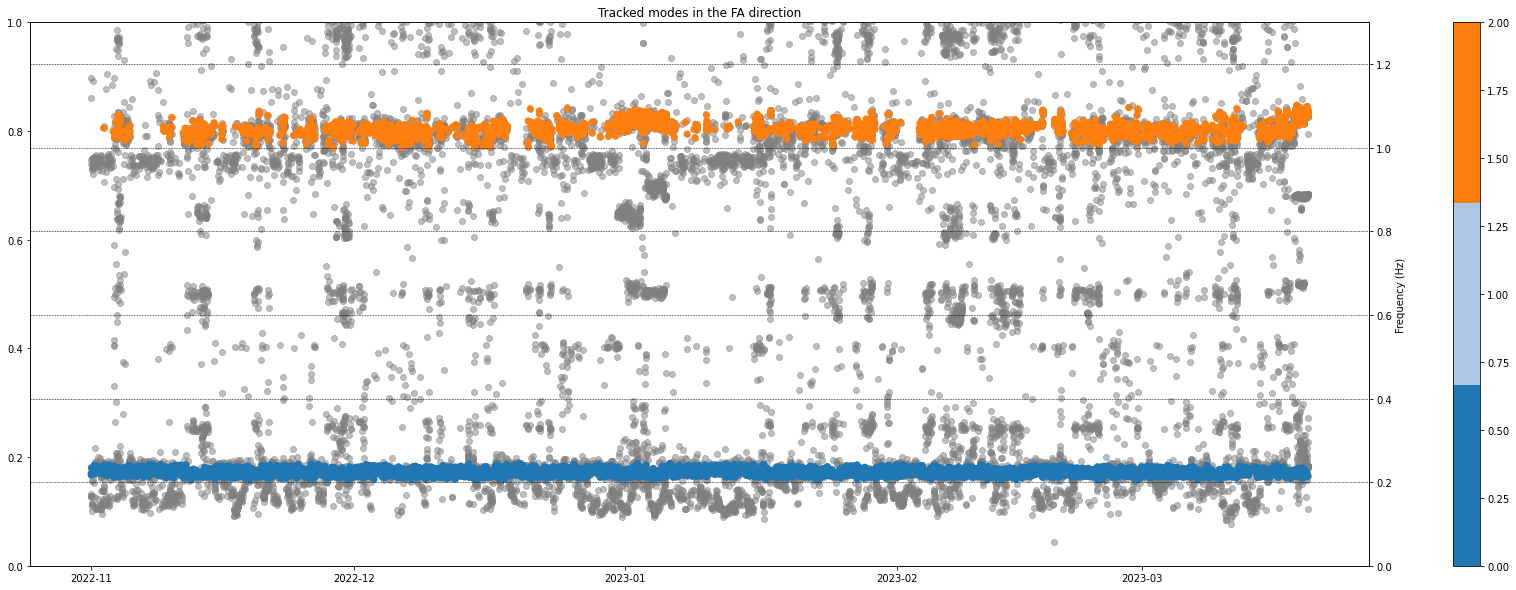

In [21]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the ' + direction + ' direction')
plt.ylim(0, 1.3)

plt.show()

FA1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
FA1_harmonics_removed = FA1_harmonics_removed[~FA1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
FA2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 2]
FA2_harmonics_removed = FA2_harmonics_removed[~FA2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

In [57]:
tracked_frequencies_hamonics_removed = \
    pd.DataFrame(
        {
            'SS1': SS1_harmonics_removed['frequency'],
            'SS2': SS2_harmonics_removed['frequency'],
            'FA1': FA1_harmonics_removed['frequency'],
            'FA2': FA2_harmonics_removed['frequency'],
        }
    )

tracked_frequencies_hamonics_removed.to_parquet('../../data/nw2/tracked_modes/harmonics_removed/' + location + '.parquet', compression='gzip')